In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26, read_datasets, discard_land
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, select_Equator, select_ACC, compare, plot
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted

from helpers.ann_tools import ANN, import_ANN, export_ANN
import torch
import torch.optim as optim

import hvplot.xarray
import hvplot
import cmocean
import os
from time import time

%load_ext autoreload
%autoreload 3

# pyqg

In [96]:
from pyqg_generative.tools.operators import advect, divergence, vorticity, gauss_filter
ds = xr.open_dataset('/scratch/pp2681/pyqg_generative/Reference-Default-scaled/eddy/reference_256/0.nc')

In [107]:
import xrft

In [174]:
_ds = ds.isel(time=-1).astype('float64')
nc = 64

u = _ds.u.values
v = _ds.v.values
w = vorticity(u,v)
q = _ds.q.values
psi = _ds.psi.values

uf = gauss_filter(u, nc)
vf = gauss_filter(v, nc)
wf = gauss_filter(w, nc)
qf = gauss_filter(q, nc)
psif = gauss_filter(psi, nc)

dds = xr.Dataset()
dds['SGS_total'] = xr.DataArray(gauss_filter(advect(q,u,v), nc) - advect(qf,uf,vf), dims=['lev','y','x'])
dds['SGS_rel'] = xr.DataArray(gauss_filter(advect(w,u,v), nc) - advect(wf,uf,vf), dims=['lev','y','x'])
dds['psif'] = xr.DataArray(psif, dims=['lev','y','x'])
dds['x'] = ds.x
dds['y'] = ds.y

Etotal = np.real(xrft.isotropic_cross_spectrum(dds['psif'], dds['SGS_total'], dim=('y', 'x')))
print(Etotal.sum().values)
Etotal = Etotal * Etotal['freq_r']
KE = np.real(xrft.isotropic_cross_spectrum(dds['psif'], dds['SGS_rel'], dim=('y', 'x')))
print(KE.sum().values)
KE = KE * KE['freq_r']
PE = Etotal-KE


8.068617029017733e-07
1.5363369834855828e-06


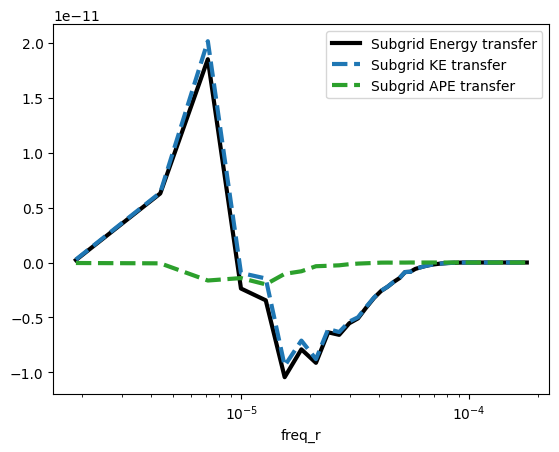

In [175]:
Etotal.sum('lev').plot(color='k', label='Subgrid Energy transfer', lw=3)
KE.sum('lev').plot(label='Subgrid KE transfer', lw=3, ls='--')
PE.sum('lev').plot(label='Subgrid APE transfer', lw=3, ls='--', color='tab:green')
plt.xscale('log')
plt.legend()

# Trained models. offline skill

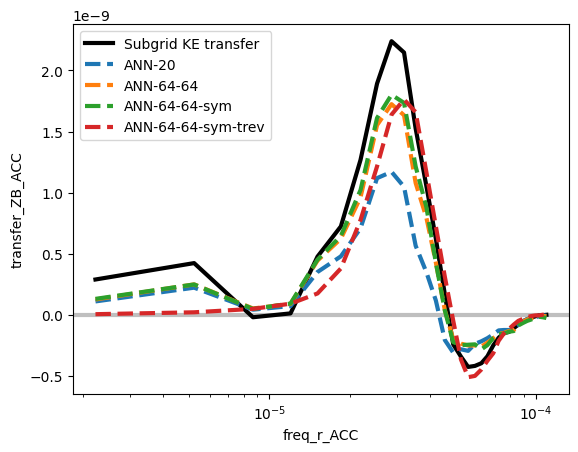

In [102]:
def read(exp='hdn-20', factor=4, dataset='test'):
    return xr.open_dataset(f'/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/{exp}/skill-{dataset}/factor-{factor}.nc')

exp = 'hdn-64-64-sym-trev'
read('hdn-20',6).transfer_ACC.mean('time').plot(label='Subgrid KE transfer',lw=3, color='k')
read('hdn-20',6).transfer_ZB_ACC.mean('time').plot(label='ANN-20',lw=3,ls='--')
read('hdn-64-64',6).transfer_ZB_ACC.mean('time').plot(label='ANN-64-64',lw=3,ls='--')
read('hdn-64-64-sym',6).transfer_ZB_ACC.mean('time').plot(label='ANN-64-64-sym',lw=3,ls='--')
read('hdn-64-64-sym-trev',6).transfer_ZB_ACC.mean('time').plot(label='ANN-64-64-sym-trev',lw=3,ls='--')
#read('hdn-64-64-sym',4).transfer_ZB_Pacific.mean('time').plot(label='ANN',lw=3,ls='--', color='tab:orange')
plt.xscale('log')
plt.legend()
plt.axhline(y=0,color='gray',alpha=0.5,zorder=-1,lw=3)

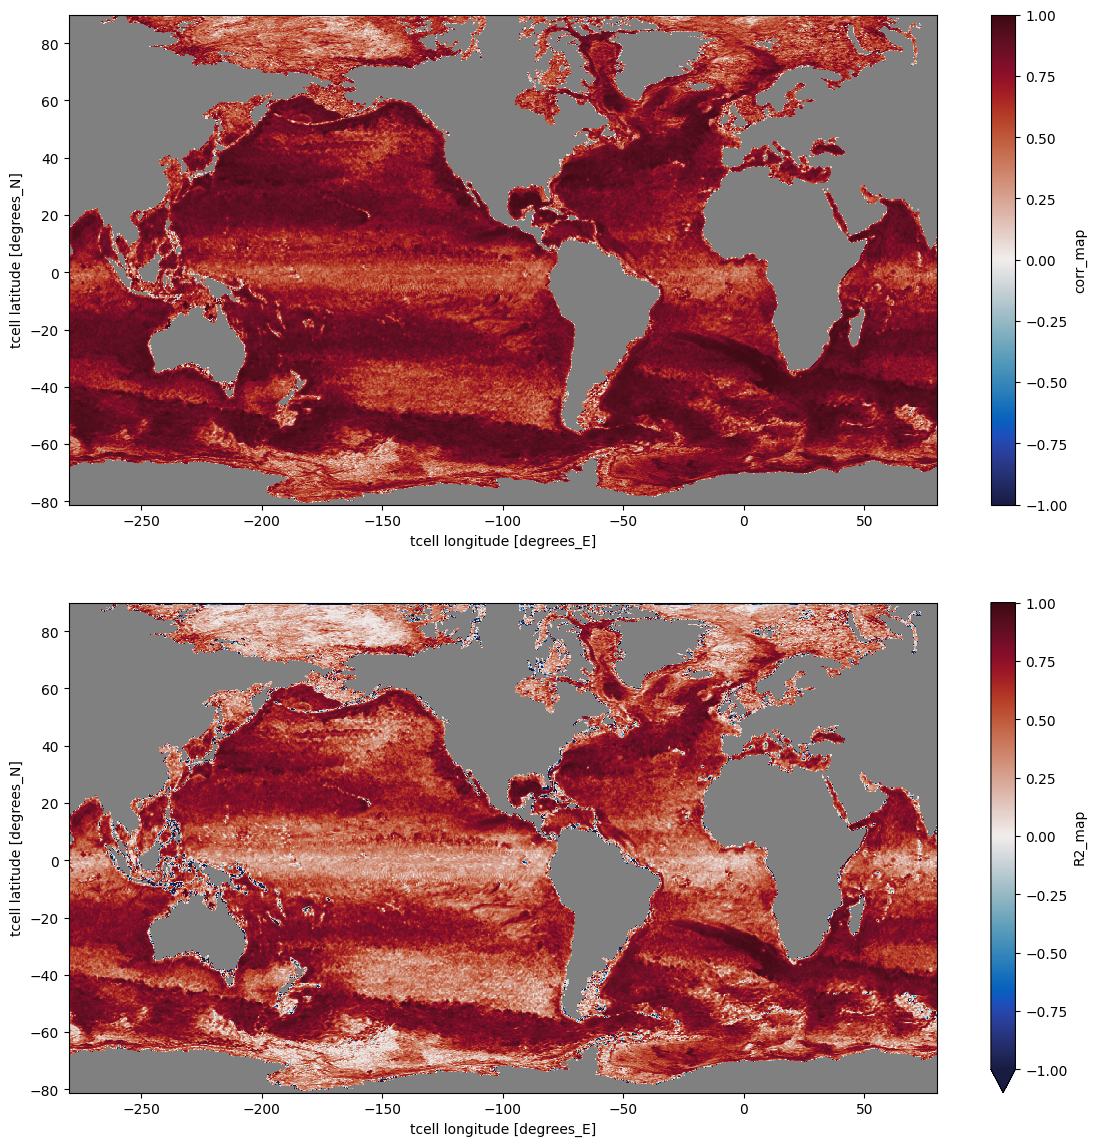

In [106]:
plt.figure(figsize=(14,14))
plt.subplot(2,1,1)
plot(read('hdn-64-64-sym').corr_map, vmax=1, vmin=-1, selector=select_globe, cartopy=False)
plt.subplot(2,1,2)
plot(read('hdn-64-64-sym').R2_map, vmax=1, vmin=-1, selector=select_globe, cartopy=False)

Correlation: 0.9209755469438984
Relative Error: 0.1349160075187683
R2 =  0.8463950008153915
R2 max =  0.8487852662801743
Optinal scaling: 1.0560413599014282
Nans [test/control]: [14574, 14574]


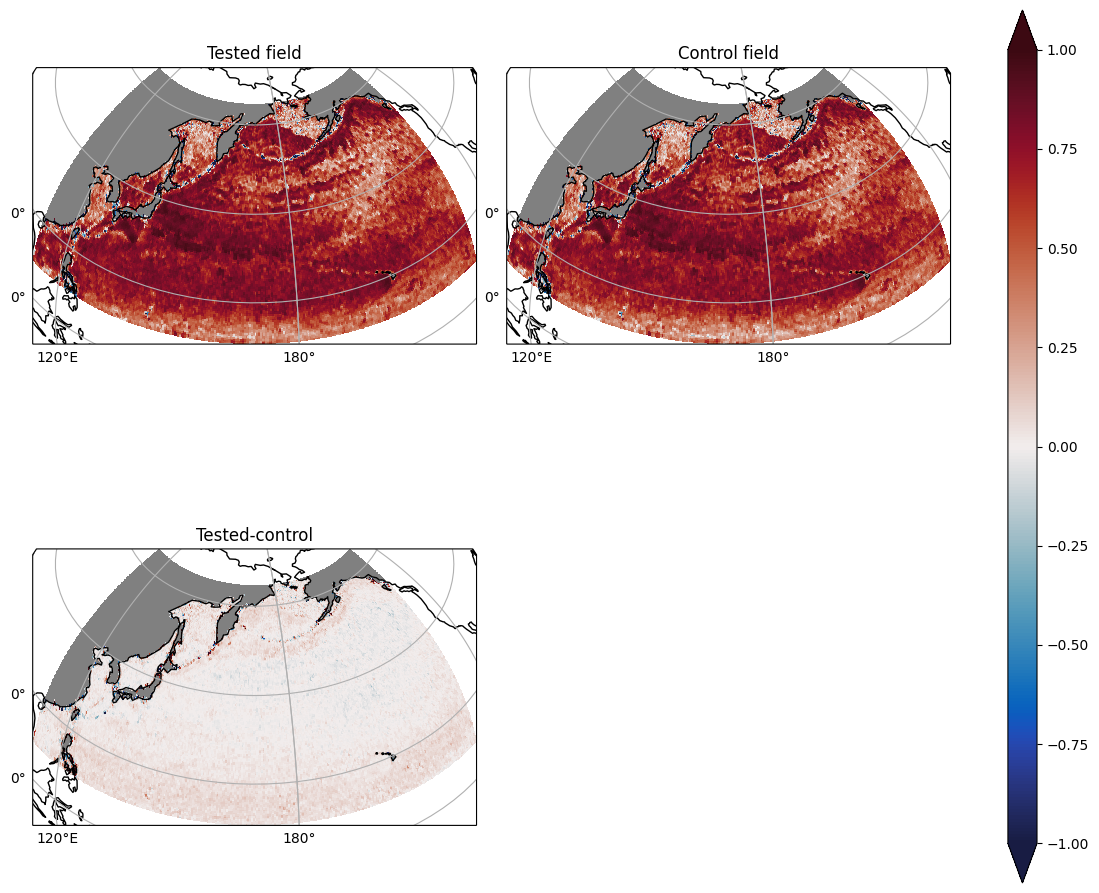

In [84]:
compare(read('hdn-64-64-sym').R2v_map, read('hdn-64-64').R2v_map, vmax=1, vmin=-1, selector=select_Pacific)

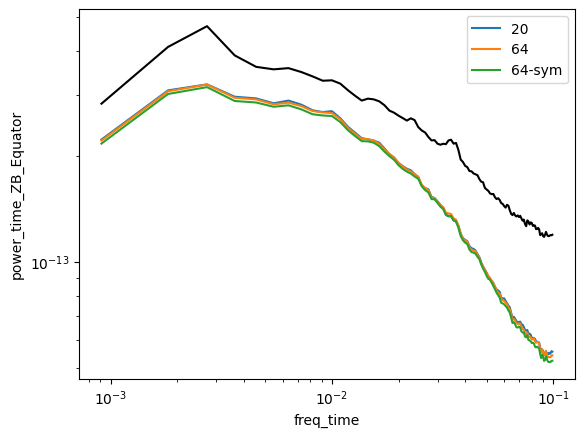

In [119]:
factor = 4
read('hdn-64-64-sym',factor).power_time_Equator.plot(color='k')
read('hdn-20',factor).power_time_ZB_Equator.plot(label='20')
read('hdn-64-64',factor).power_time_ZB_Equator.plot(label='64')
read('hdn-64-64-sym',factor).power_time_ZB_Equator.plot(label='64-sym')
#read('hdn-64-64-sym-trev',factor).power_time_ZB_Equator.plot(label='64-sym')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [134]:
print(read('hdn-64-64-sym',12,'test').R2.values, read('hdn-64-64-sym',12,'train').R2.values)

0.6065942645072937 0.6030495166778564


In [135]:
print(read('hdn-64-64',12,'test').R2.values, read('hdn-64-64',12,'train').R2.values)

0.606426864862442 0.6042053401470184


# Online runs

In [498]:
ds = xr.open_mfdataset('/scratch/pp2681/mom6/regression_tests/R4/mom_*.nc', decode_times=False)
prog = xr.open_mfdataset('/scratch/pp2681/mom6/regression_tests/R4/prog_*.nc', decode_times=False)
series = xr.open_mfdataset('/scratch/pp2681/mom6/regression_tests/R4/series_*.nc', decode_times=False)

In [491]:
ds.SGS_KE.hvplot(x='xh', y='yh', height=500, width=400) + ds.Txx.hvplot(x='xh', y='yh', height=500, width=400)

:Layout
   .DynamicMap.I  :DynamicMap   [Time,zl]
      :Image   [xh,yh]   (SGS_KE)
   .DynamicMap.II :DynamicMap   [Time,zl]
      :Image   [xh,yh]   (Txx)

In [497]:
(-(ds.Txx+ds.Tyy)*0.5).hvplot(x='xh', y='yh', height=500)

:DynamicMap   [Time,zl]
   :Image   [xh,yh]   (value)

In [505]:
prog.RV.hvplot(x='xq', y='yq',height=500, width=400, cmap='bwr', clim=(-2e-5,2e-5))\
+ ds.visc_coef.hvplot(x='xh', y='yh', width=400, height=500)

:Layout
   .DynamicMap.I  :DynamicMap   [Time,zl]
      :Image   [xq,yq]   (RV)
   .DynamicMap.II :DynamicMap   [Time,zl]
      :Image   [xh,yh]   (visc_coef)

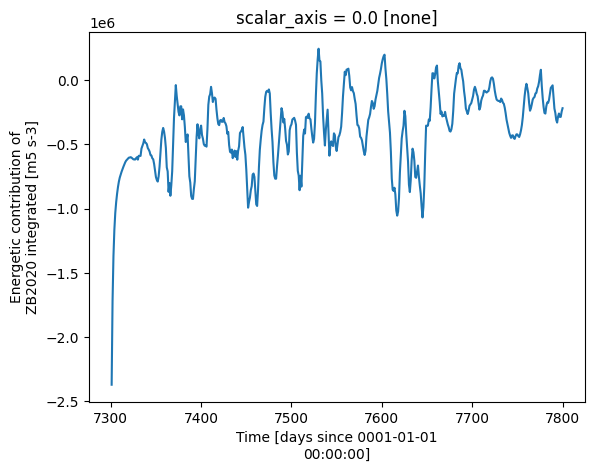

In [504]:
series.KE_ZB.plot()

In [427]:
SGS_KE_est = - (ds.Txx + ds.Tyy)*0.5

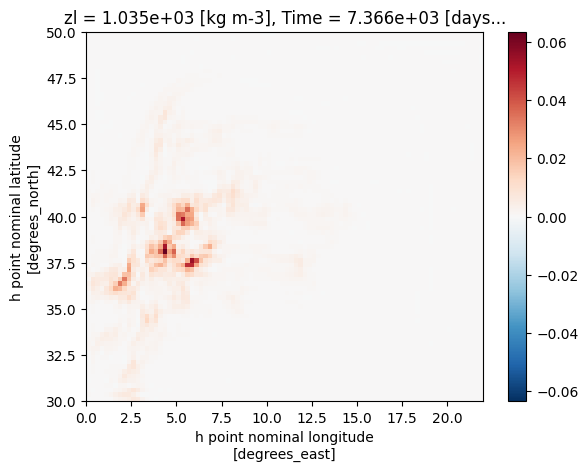

In [428]:
SGS_KE_est.isel(zl=0).plot()

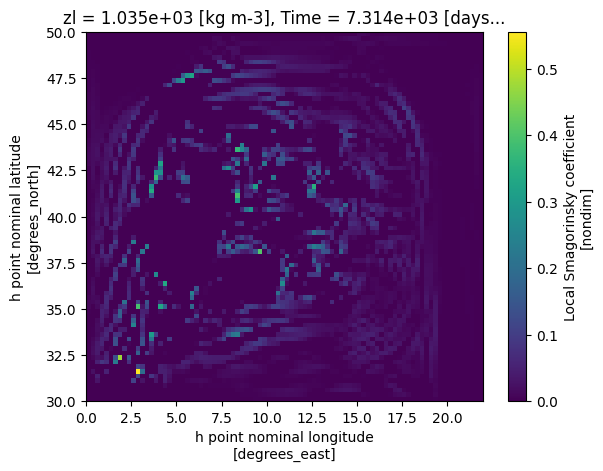

In [400]:
ds.smag_coef.isel(zl=0).plot()

In [372]:
ZB = np.minimum(ds.Esrc_ZB.isel(Time=-1,zl=0),0.0)
Diss = ds.Esrc_smag.isel(Time=-1,zl=0)

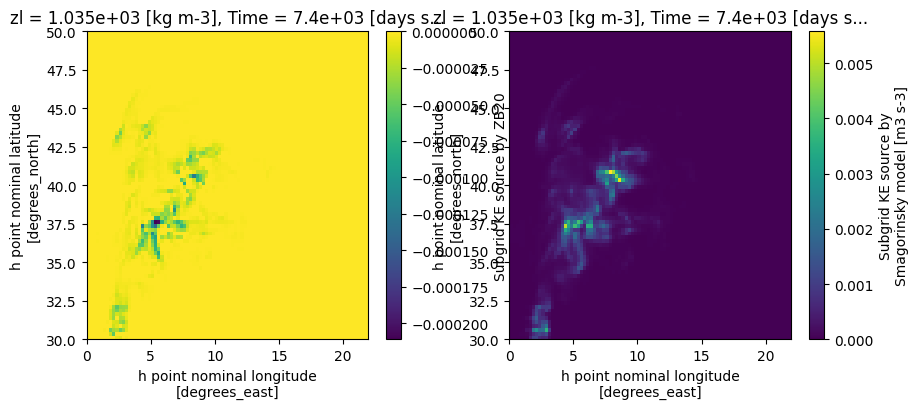

In [376]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
ZB.plot()
plt.subplot(1,2,2)
Diss.plot()

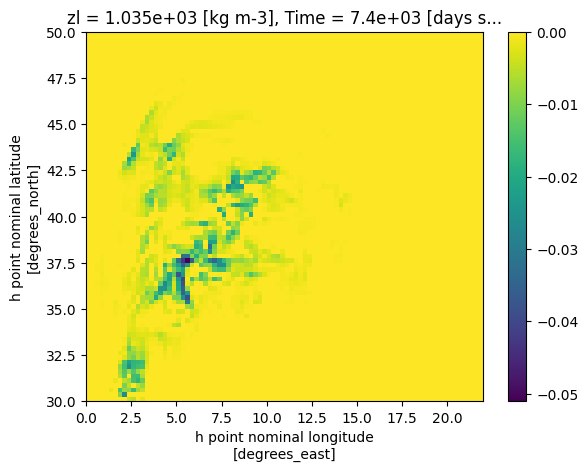

In [380]:
(ZB / (Diss+0.001)).plot()

In [507]:
mom = xr.open_mfdataset('/scratch/pp2681/mom6/regression_tests/R4/mom__*', 
                  decode_times=False).load()
prog = xr.open_mfdataset('/scratch/pp2681/mom6/regression_tests/R4/prog__*', 
                  decode_times=False).load()

In [510]:
def plot(idx):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    prog.isel(Time=idx).RV.isel(zl=0).plot(cmap='seismic', vmax=2e-5)
    plt.title('Relative vorticity')
    plt.axis('off')
    plt.subplot(1,2,2)
    mom.isel(Time=idx).visc_coef.isel(zl=0).plot(cmap='inferno', vmax=1000)
    plt.title('Viscosity')
    plt.axis('off')

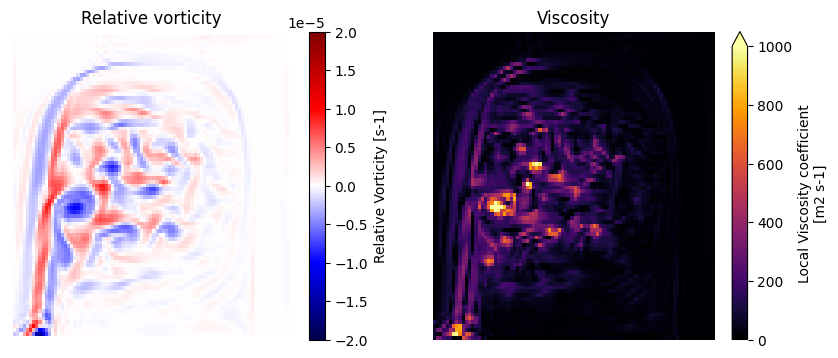

In [511]:
plot(0)

In [513]:
from helpers.plot_helpers import create_animation_ffmpeg
%time create_animation_ffmpeg(plot, range(500), FPS=30, filename='Local_viscosity.mp4', dpi=200)

Native resolution of snapshots is used: 1676x714

Animation Local_viscosity.mp4 at FPS=30 will last for 16.7 seconds. The frames are saved to 
.ffmpeg/Local_viscosity



ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

CPU times: user 2min 57s, sys: 3.62 s, total: 3min 1s
Wall time: 3min 30s


frame=  500 fps= 19 q=26.0 Lsize=    5118kB time=00:00:16.56 bitrate=2530.6kbits/s speed=0.618x    
video:5111kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.126831%
[libx264 @ 0x56467aa7f700] frame I:2     Avg QP:17.41  size: 73026
[libx264 @ 0x56467aa7f700] frame P:160   Avg QP:17.70  size: 23400
[libx264 @ 0x56467aa7f700] frame B:338   Avg QP:21.97  size:  3973
[libx264 @ 0x56467aa7f700] consecutive B-frames:  9.4%  1.2%  0.6% 88.8%
[libx264 @ 0x56467aa7f700] mb I  I16..4: 20.0% 40.9% 39.1%
[libx264 @ 0x56467aa7f700] mb P  I16..4:  1.3%  2.6%  4.3%  P16..4: 14.3%  7.6%  5.5%  0.0%  0.0%    skip:64.5%
[libx264 @ 0x56467aa7f700] mb B  I16..4:  0.1%  0.3%  0.1%  B16..8: 12.5%  1.5%  0.7%  direct: 3.8%  skip:80.9%  L0:41.5% L1:52.8% BI: 5.7%
[libx264 @ 0x56467aa7f700] 8x8 transform intra:35.1% inter:53.5%
[libx264 @ 0x56467aa7f700] coded y,uvDC,uvAC intra: 46.8% 64.1% 57.2% inter: 7.7% 9.3% 4.4%
[libx264 @ 0x56467aa7f700] i16 v,h,dc,p: 59% 34%  5%  2%
[

# Does it overpredict backscatter?

In [2]:
ds = read_datasets('Coarsen', factors=[4])

Dataset has been read: Coarsen-train-4
Dataset has been read: Coarsen-test-4


In [3]:
ann_Txy = import_ANN('../trained_models/ANN_CM26_grid_harmonic_ver3/Txy_epoch_1000.nc')
ann_Txx_Tyy = import_ANN('../trained_models/ANN_CM26_grid_harmonic_ver3/Txx_Tyy_epoch_1000.nc')
%time skill = ds['test-4'].split(slice(None,None,4)).predict_ANN(ann_Txy, ann_Txx_Tyy).SGS_skill()

CPU times: user 1min 10s, sys: 40.2 s, total: 1min 50s
Wall time: 1min 54s


In [30]:
ann_Txy = import_ANN('../trained_models/ANN_CM26/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('../trained_models/ANN_CM26/Txx_Tyy_epoch_2000.nc')
%time skill_bare = ds['test-4'].split(slice(None,None,4)).predict_ANN(ann_Txy, ann_Txx_Tyy).SGS_skill()

CPU times: user 1min 10s, sys: 36.2 s, total: 1min 47s
Wall time: 1min 48s


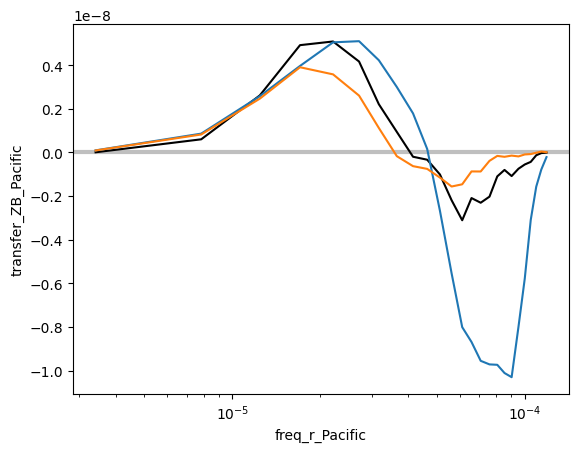

In [41]:
skill.transfer_Pacific.mean('time').plot(color='k')
skill.transfer_ZB_Pacific.mean('time').plot()
skill_bare.transfer_ZB_Pacific.mean('time').plot()
plt.axhline(y=0, color='gray', lw=3, zorder=-1, alpha=0.5)
plt.xscale('log')

Correlation: 0.8512455868197435
Relative Error: 0.5847089886665344
R2 =  0.6829911172389984
R2 max =  0.7259544432163239
Optinal scaling: 1.3214807510375977
Nans [test/control]: [0, 0]


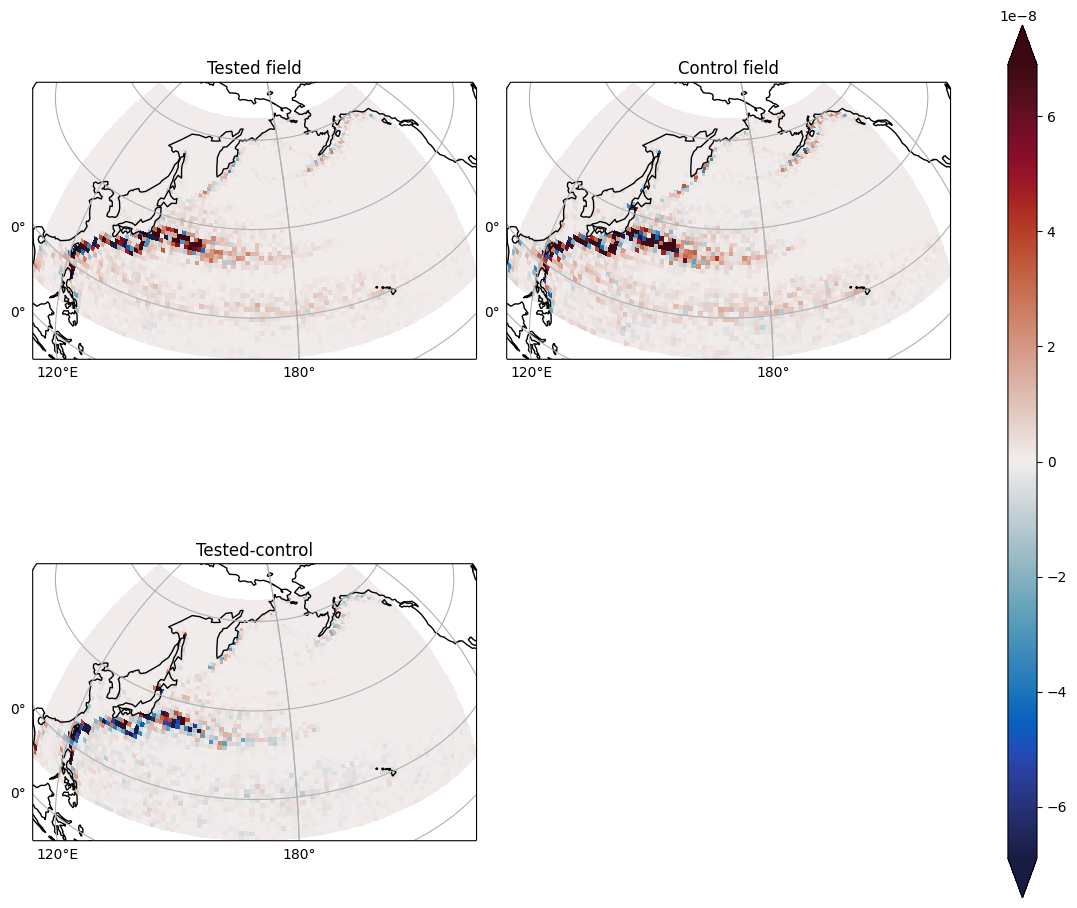

In [42]:
compare(skill_bare.Esource_ZB_map.coarsen({'xh':3, 'yh':3}, 'trim').mean(), 
        skill.Esource_map.coarsen({'xh':3, 'yh':3}, 'trim').mean(),
        selector=select_Pacific)

In [44]:
skill.Esource_ZB

<xarray.DataArray 'Esource_ZB' ()>
array(-0.4476253, dtype=float32)

# Analysis of dissipation on snapshots

In [56]:
ann_Txy = import_ANN('../trained_models/ANN_CM26_grid_harmonic_ver3/Txy_epoch_1000.nc')
ann_Txx_Tyy = import_ANN('../trained_models/ANN_CM26_grid_harmonic_ver3/Txx_Tyy_epoch_1000.nc')
s = ds['test-4'].split().state.EZ_source_ANN(ann_Txy, ann_Txx_Tyy)

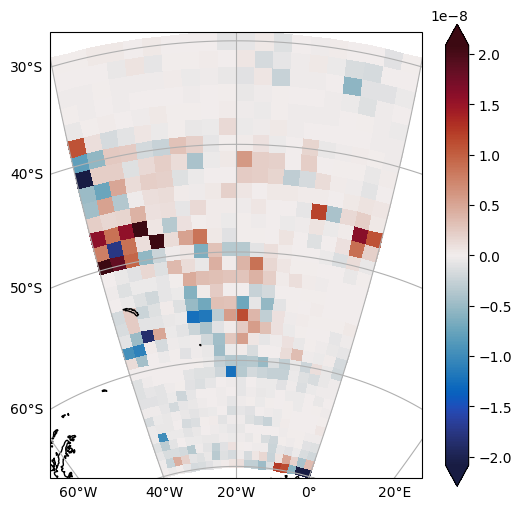

In [65]:
plot(s['dEdt_G'].coarsen({'xh':5, 'yh':5}).mean(),selector=select_ACC)